In [132]:
import pandas as pd
import numpy as np
import glob
import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("data/data-2/Kickstarter000.csv")

In [4]:
data.head(1)

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,...,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type
0,21,2006 was almost 7 years ago.... Can you believ...,"{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",802,US,1387659690,"{""id"":1495925645,""name"":""Daniel"",""is_registere...",USD,$,True,...,new-final-round-album,https://www.kickstarter.com/discover/categorie...,True,False,successful,1391899046,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",802.0,international


In [5]:
# check out colum that looks like json
data["category"].iloc[3]

'{"id":266,"name":"Footwear","slug":"fashion/footwear","position":5,"parent_id":9,"color":16752598,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/fashion/footwear"}}}'

# Data Cleaning for a better Baseline Model.
We look at fx_rate, goal, state

In [6]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3779 entries, 0 to 3778
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   backers_count             3779 non-null   int64  
 1   blurb                     3779 non-null   object 
 2   category                  3779 non-null   object 
 3   converted_pledged_amount  3779 non-null   int64  
 4   country                   3779 non-null   object 
 5   created_at                3779 non-null   int64  
 6   creator                   3779 non-null   object 
 7   currency                  3779 non-null   object 
 8   currency_symbol           3779 non-null   object 
 9   currency_trailing_code    3779 non-null   bool   
 10  current_currency          3779 non-null   object 
 11  deadline                  3779 non-null   int64  
 12  disable_communication     3779 non-null   bool   
 13  friends                   8 non-null      object 
 14  fx_rate 

In [7]:
# create dataframe 
df_bs = data[["goal", "fx_rate", "state"]]

In [8]:
df_bs.head()

,goal,fx_rate,state
0,200.0,1.000000,successful
1,400.0,1.000000,successful
2,27224.0,1.000000,successful
3,40000.0,1.128433,successful
4,1000.0,1.000000,failed


In [9]:
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3779 entries, 0 to 3778
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   goal     3779 non-null   float64
 1   fx_rate  3779 non-null   float64
 2   state    3779 non-null   object 
dtypes: float64(2), object(1)
memory usage: 88.7+ KB


In [10]:
df_bs.state.unique()

array(['successful', 'failed', 'live', 'canceled', 'suspended'],
      dtype=object)

In [11]:
df_bs.drop(df_bs[df_bs["state"] == "live"].index, inplace=True)
df_bs.drop(df_bs[df_bs["state"] == "canceled"].index, inplace=True)
df_bs.drop(df_bs[df_bs["state"] == "suspended"].index, inplace=True)

In [12]:
df_bs.state.unique()

array(['successful', 'failed'], dtype=object)

In [13]:
df_bs["all_usd"] = df_bs["goal"] * df_bs["fx_rate"]

In [14]:
df_bs.head()

,goal,fx_rate,state,all_usd
0,200.0,1.000000,successful,200.000
1,400.0,1.000000,successful,400.000
2,27224.0,1.000000,successful,27224.000
3,40000.0,1.128433,successful,45137.302
4,1000.0,1.000000,failed,1000.000


In [15]:
df_bs.drop(["goal", "fx_rate"], axis="columns", inplace=True)
df_bs.describe()

,all_usd
count,3.500000e+03
mean,2.200860e+04
std,1.313098e+05
min,7.512245e-01
25%,1.325680e+03
50%,4.891480e+03
75%,1.200000e+04
max,5.000000e+06


In [16]:
df_bs.head()

,state,all_usd
0,successful,200.000
1,successful,400.000
2,successful,27224.000
3,successful,45137.302
4,failed,1000.000


<AxesSubplot:>

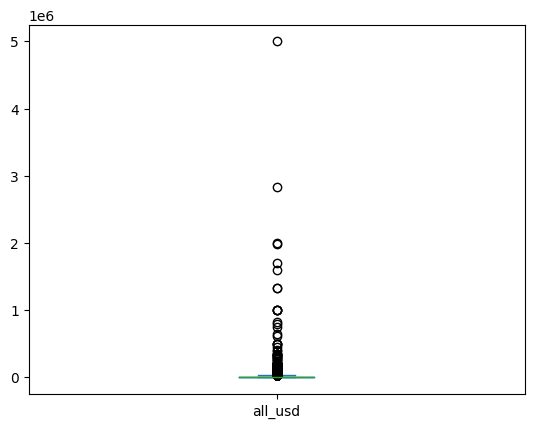

In [17]:
df_bs.plot(kind="box", x="state", y="all_usd")

In [18]:
all_usd_med = df_bs.all_usd.median()
all_usd_mean = df_bs.all_usd.mean()
print(f"med: {all_usd_med}, mean: {all_usd_mean}")

med: 4891.479625, mean: 22008.597004688632


In [19]:

df_bs["above_median"] =  df_bs.all_usd.apply(lambda x: 1 if x > all_usd_med else 0)
df_bs["above_mean"] =  df_bs.all_usd.apply(lambda x: 1 if x > all_usd_mean else 0)

df_bs.head()


,state,all_usd,above_median,above_mean
0,successful,200.000,0,0
1,successful,400.000,0,0
2,successful,27224.000,1,1
3,successful,45137.302,1,1
4,failed,1000.000,0,0


In [20]:
df_bs["state_transformed"] =  df_bs.state.apply(lambda x: 1 if x == "successful" else 0)


In [21]:
from sklearn.metrics import confusion_matrix, classification_report

y_true = df_bs.state_transformed
y_pred_med = df_bs.above_median
y_pred_mean = df_bs.above_mean

print("Metrics for median: ")
print(confusion_matrix(y_true=y_true, y_pred=y_pred_med))
print(classification_report(y_true, y_pred_med))

print("-------"*10)
print("Metrics for mean: ")
print(confusion_matrix(y_true=y_true, y_pred=y_pred_mean))
print(classification_report(y_true, y_pred_mean))

Metrics for median: 
[[ 484  792]
 [1266  958]]
              precision    recall  f1-score   support

           0       0.28      0.38      0.32      1276
           1       0.55      0.43      0.48      2224

    accuracy                           0.41      3500
   macro avg       0.41      0.41      0.40      3500
weighted avg       0.45      0.41      0.42      3500

----------------------------------------------------------------------
Metrics for mean: 
[[ 928  348]
 [2010  214]]
              precision    recall  f1-score   support

           0       0.32      0.73      0.44      1276
           1       0.38      0.10      0.15      2224

    accuracy                           0.33      3500
   macro avg       0.35      0.41      0.30      3500
weighted avg       0.36      0.33      0.26      3500



In [24]:
data.name.unique()

array(['New Final Round Album', 'Princess Pals Enamel Pin Series',
       'Their Life Through Their Lens-the Amish and Mennonite People',
       ..., '"Summer Rec" Pilot Episode',
       "IT'S NOT ABOUT YOU: undergraduate student thesis film",
       'A cool and thought provoking t-shirt line.'], dtype=object)

In [25]:
data.slug.unique()

array(['new-final-round-album', 'princess-pals-enamel-pin-series',
       'their-life-through-their-lens-the-amish-and-mennon', ...,
       'summer-rec-pilot-episode',
       'its-not-about-you-undergraduate-student-thesis-fil',
       'a-cool-and-thought-provoking-t-shirt-line'], dtype=object)

In [34]:
import json

# some JSON:
x =  '{ "name":"John", "age":30, "city":"New York"}'

# parse x:
y = json.loads(x)

# the result is a Python dictionary:
print(y["age"])

30


In [90]:
json.loads(data.category[1])["parent_id"]

1

In [77]:
print(y["parent_id"])

1


In [46]:
data.category[1]

'{"id":54,"name":"Mixed Media","slug":"art/mixed media","position":6,"parent_id":1,"color":16760235,"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/art/mixed%20media"}}}'

In [112]:
y = [[json.loads(data.category[i])["slug"],json.loads(data.category[i])["parent_id"]] for i in range(31)]

In [113]:
y.sort()

In [114]:
y

[['art/mixed media', 1],
 ['art/mixed media', 1],
 ['art/sculpture', 1],
 ['fashion/accessories', 9],
 ['fashion/accessories', 9],
 ['fashion/footwear', 9],
 ['fashion/footwear', 9],
 ['fashion/footwear', 9],
 ['food/restaurants', 10],
 ['food/small batch', 10],
 ['games/playing cards', 12],
 ['games/playing cards', 12],
 ['music/classical music', 14],
 ['music/classical music', 14],
 ['music/country & folk', 14],
 ['music/rock', 14],
 ['music/rock', 14],
 ['music/rock', 14],
 ['photography/fine art', 15],
 ['photography/nature', 15],
 ['photography/photobooks', 15],
 ['photography/photobooks', 15],
 ['publishing/nonfiction', 18],
 ['publishing/nonfiction', 18],
 ['publishing/nonfiction', 18],
 ['publishing/nonfiction', 18],
 ['technology/software', 16],
 ['technology/software', 16],
 ['technology/software', 16],
 ['theater/festivals', 17],
 ['theater/musical', 17]]

In [96]:
json.loads(data.category[0])["parent_id"]

14

In [110]:
y = [json.loads(data.category[i]).get("parent_id") for i in range(32)]

In [111]:
y

[14,
 1,
 15,
 9,
 16,
 9,
 18,
 16,
 1,
 12,
 15,
 18,
 9,
 9,
 12,
 10,
 15,
 15,
 17,
 1,
 14,
 14,
 10,
 16,
 18,
 17,
 9,
 14,
 14,
 14,
 18,
 None]

In [116]:
json_df = data['category'].apply(json.loads)
json_column = pd.DataFrame(json_df.tolist())

In [125]:
json_column.parent_id

0       14.0
1        1.0
2       15.0
3        9.0
4       16.0
        ... 
3774    14.0
3775    12.0
3776    11.0
3777    11.0
3778     9.0
Name: parent_id, Length: 3779, dtype: float64

In [129]:
data_wide = pd.concat([data, json_column.parent_id], axis=1)

In [130]:
data_wide

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,...,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,parent_id
0,21,2006 was almost 7 years ago.... Can you believ...,"{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",802,US,1387659690,"{""id"":1495925645,""name"":""Daniel"",""is_registere...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1391899046,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",802.00000,international,14.0
1,97,An adorable fantasy enamel pin series of princ...,"{""id"":54,""name"":""Mixed Media"",""slug"":""art/mixe...",2259,US,1549659768,"{""id"":1175589980,""name"":""Katherine"",""slug"":""fr...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1551801611,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",2259.00000,international,1.0
2,88,Helping a community come together to set the s...,"{""id"":280,""name"":""Photobooks"",""slug"":""photogra...",29638,US,1477242384,"{""id"":1196856269,""name"":""MelissaThomas"",""is_re...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,True,True,successful,1480607932,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",29638.00000,international,15.0
3,193,Every revolution starts from the bottom and we...,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",49158,IT,1540369920,"{""id"":1569700626,""name"":""WAO"",""slug"":""wearewao...",EUR,€,False,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1544309940,1.136525,"{""web"":{""project"":""https://www.kickstarter.com...",49075.15252,international,9.0
4,20,Learn to build 10+ Applications in this comple...,"{""id"":51,""name"":""Software"",""slug"":""technology/...",549,US,1425706517,"{""id"":1870845385,""name"":""Kalpit Jain"",""is_regi...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1428511019,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",549.00000,domestic,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3774,10,"This is a collaborative effort at recording, m...","{""id"":316,""name"":""Blues"",""slug"":""music/blues"",...",506,US,1454527113,"{""id"":1000214737,""name"":""Penny D Marcucci"",""is...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1459716419,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",506.00000,domestic,14.0
3775,472,Get your own Mimic Chest containing dice vault...,"{""id"":270,""name"":""Gaming Hardware"",""slug"":""gam...",75790,US,1506288614,"{""id"":1342562240,""name"":""Polymorph Crafts"",""sl...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1510934334,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",75790.00000,international,12.0
3776,35,"A new animated, workplace comedy series about ...","{""id"":29,""name"":""Animation"",""slug"":""film & vid...",2346,US,1336120969,"{""id"":765327036,""name"":""Daran Carlin-Weber"",""i...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,False,False,failed,1339046590,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",2346.00000,international,11.0
3777,13,a thesis film following the emotional life of ...,"{""id"":32,""name"":""Shorts"",""slug"":""film & video/...",1901,US,1537154407,"{""id"":1521393087,""name"":""Carolyn Ramella"",""is_...",USD,$,True,...,https://www.kickstarter.com/discover/categorie...,True,False,successful,1543349869,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1901.00000,international,11.0


In [131]:
data_wide.parent_id.unique()

array([14.,  1., 15.,  9., 16., 18., 12., 10., 17., nan,  6., 13., 11.,
        3., 26.,  7.])

In [133]:
all_files = glob.glob(os.path.join('data/data-2', "*.csv"))
all_files.sort()
all_files

['data/data-2/Kickstarter000.csv',
 'data/data-2/Kickstarter001.csv',
 'data/data-2/Kickstarter002.csv',
 'data/data-2/Kickstarter003.csv',
 'data/data-2/Kickstarter004.csv',
 'data/data-2/Kickstarter005.csv',
 'data/data-2/Kickstarter006.csv',
 'data/data-2/Kickstarter007.csv',
 'data/data-2/Kickstarter008.csv',
 'data/data-2/Kickstarter009.csv',
 'data/data-2/Kickstarter010.csv',
 'data/data-2/Kickstarter011.csv',
 'data/data-2/Kickstarter012.csv',
 'data/data-2/Kickstarter013.csv',
 'data/data-2/Kickstarter014.csv',
 'data/data-2/Kickstarter015.csv',
 'data/data-2/Kickstarter016.csv',
 'data/data-2/Kickstarter017.csv',
 'data/data-2/Kickstarter018.csv',
 'data/data-2/Kickstarter019.csv',
 'data/data-2/Kickstarter020.csv',
 'data/data-2/Kickstarter021.csv',
 'data/data-2/Kickstarter022.csv',
 'data/data-2/Kickstarter023.csv',
 'data/data-2/Kickstarter024.csv',
 'data/data-2/Kickstarter025.csv',
 'data/data-2/Kickstarter026.csv',
 'data/data-2/Kickstarter027.csv',
 'data/data-2/Kickst

In [134]:
merged_df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

In [135]:
json_df = merged_df['category'].apply(json.loads)
json_column = pd.DataFrame(json_df.tolist())

In [137]:
legend = pd.concat([json_column.slug, json_column.parent_id], axis=1)

In [144]:
id_legend = legend.sort_values('parent_id').drop_duplicates().set_index('parent_id')

In [157]:
minislug = [json_column.slug[i].split('/')[0] for i in range(len(json_column))]

In [159]:
df_mini = pd.DataFrame({'minislug':minislug})

In [160]:
legend = pd.concat([df_mini, json_column.parent_id], axis=1)

In [161]:
id_legend = legend.sort_values('parent_id').drop_duplicates().set_index('parent_id')

In [162]:
id_legend

,minislug
parent_id,
1.0,art
3.0,comics
6.0,dance
7.0,design
9.0,fashion
10.0,food
11.0,film & video
12.0,games
13.0,journalism
